Phase Estimation Benchmark Program - Cirq
... execution starting at Jun 10, 2024 10:46:41 UTC
************
Executing [2] circuits with num_qubits = 3
Average Creation, Elapsed, Execution Time for the 3 qubit group = 0.001, 0.075, 0.039 secs
Average Hellinger, Normalized Fidelity for the 3 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 4
Average Creation, Elapsed, Execution Time for the 4 qubit group = 0.002, 0.018, 0.007 secs
Average Hellinger, Normalized Fidelity for the 4 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 5
Average Creation, Elapsed, Execution Time for the 5 qubit group = 0.002, 0.022, 0.009 secs
Average Hellinger, Normalized Fidelity for the 5 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 6
Average Creation, Elapsed, Execution Time for the 6 qubit group = 0.002, 0.026, 0.011 secs
Average Hellinger, Normalized Fidelity for the 6 qubit group = 1.0, 1.0

************
Executing [3]

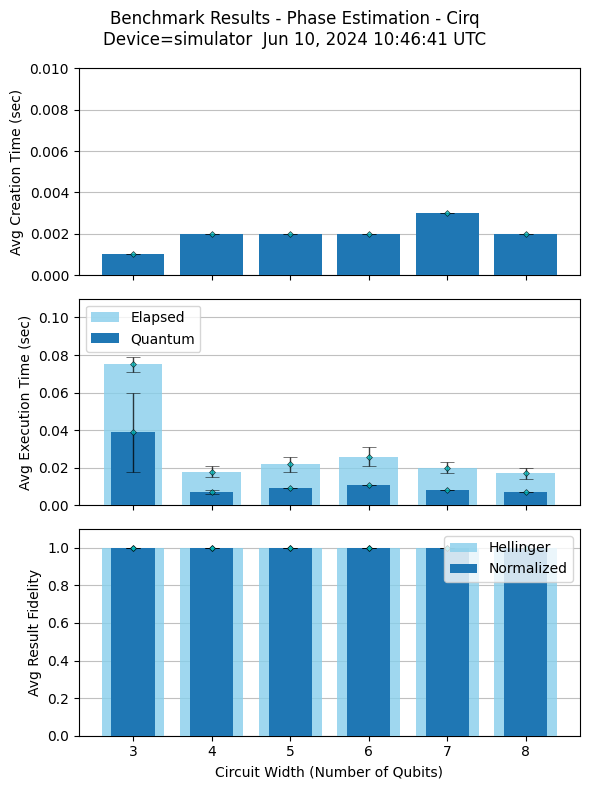

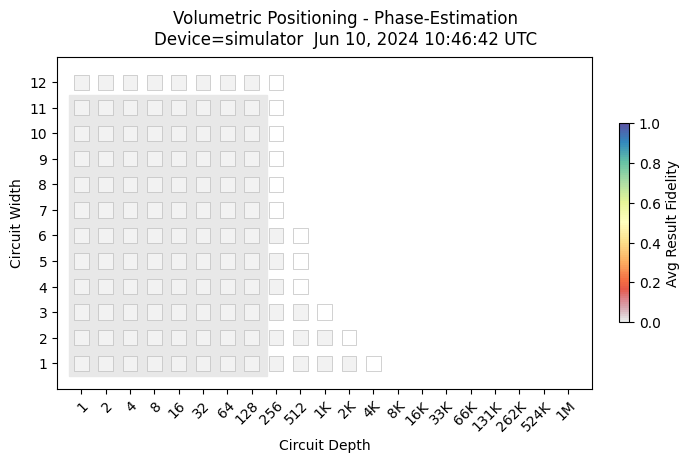

In [1]:
"""
Phase Estimation Benchmark Program - Cirq
"""

from collections import defaultdict
import sys
import time

import cirq
import numpy as np

sys.path[1:1] = ["_common", "_common/cirq", "quantum-fourier-transform/cirq"]
sys.path[1:1] = ["../../_common", "../../_common/cirq", "../../quantum-fourier-transform/cirq"]
import cirq_utils as cirq_utils
import execute as ex
import metrics as metrics
from qft_benchmark import inv_qft_gate

np.random.seed(0)

verbose = False

# saved circuits for display
QC_ = None
QFTI_ = None
U_ = None

############### Circuit Definition

def PhaseEstimation(num_qubits, theta):
    
    qr = [cirq.GridQubit(i, 0) for i in range(num_qubits)]
    qc = cirq.Circuit()
    
    num_counting_qubits = num_qubits - 1 # only 1 state qubit
    
    # initialize counting qubits in superposition
    qc.append(cirq.H.on_each(*qr[:num_counting_qubits]))
    
    # change to |1> in state qubit, so phase will be applied by cphase gate
    qc.append(cirq.X(qr[num_counting_qubits]))
    
    repeat = 1
    for j in reversed(range(num_counting_qubits)):
        # controlled operation: adds phase exp(i*2*pi*theta) to the state |1>
        #                       does nothing to state |0>
        cp, _ = CPhase(2*np.pi*theta, repeat)
        qc.append(cp.on(qr[j], qr[num_counting_qubits]))
        repeat *= 2

    #Define global U operator as the phase operator
    _, U = CPhase(2*np.pi*theta, 1)

    # inverse quantum Fourier transform only on counting qubits
    QFT_inv_gate = inv_qft_gate(num_counting_qubits)
    qc.append(QFT_inv_gate.on(*qr[:num_counting_qubits]))

    # measure counting qubits
    qc.append(cirq.measure(*qr[:num_counting_qubits], key='result'))

    # save smaller circuit example for display
    global QC_, U_, QFTI_
    if QC_ == None or num_qubits <= 5:
        if num_qubits < 9: QC_ = qc
    if U_ == None or num_qubits <= 5:
        if num_qubits < 9: U_ = U
    if QFTI_ == None or num_qubits <= 5:
        if num_qubits < 9: QFTI_ = inv_qft_gate(num_counting_qubits)

    # return a handle on the circuit
    return qc
    
#Construct the phase gates and include matching gate representation as readme circuit
def CPhase(angle, exponent):

    qr = cirq.GridQubit.rect(1,1,0)
    qc = cirq.Circuit()

    qc.append(cirq.ZPowGate(exponent=angle*exponent/np.pi).on(qr[0]))
    
    U_gate = cirq_utils.to_gate(num_qubits=1, circ=qc, name=f"U^{exponent}")
    phase_gate = cirq.ops.ControlledGate(U_gate, num_controls=1)

    return phase_gate, qc

# Analyze and print measured results
def analyze_and_print_result(qc, result, num_counting_qubits, theta, num_shots):
    
    measurements = result.measurements['result']
    
    counts_str = defaultdict(lambda: 0)
    for row in measurements:
        counts_str["".join([str(x) for x in reversed(row)])] += 1

    # get results as times a particular theta was measured    
    counts = bitstring_to_theta(counts_str, num_counting_qubits)

    # Convert keys of counts to strings
    counts = {str(key): value for key, value in counts.items()}
    
    if verbose: print(f"For theta value {theta}, measured: {counts}")
    
    # correct distribution is measuring theta 100% of the time
    correct_dist = {theta: 1.0}

    #convert the keys of the correct_dist dictionary into strings
    correct_dist = {str(key): value for key, value in correct_dist.items()}   

    # generate thermal_dist with amplitudes instead, to be comparable to correct_dist
    bit_thermal_dist = metrics.uniform_dist(num_counting_qubits)
    thermal_dist = bitstring_to_theta(bit_thermal_dist, num_counting_qubits)

    # use our polarization fidelity rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist, thermal_dist)
    
    return counts, fidelity

def bitstring_to_theta(counts, num_counting_qubits):
    theta_counts = {}
    for key in counts.keys():
        r = counts[key]
        theta = int(key,2) / (2**num_counting_qubits)
        if theta not in theta_counts.keys():
            theta_counts[theta] = 0
        theta_counts[theta] += r
    return theta_counts

################ Benchmark Loop

# Execute program with default parameters
def run(min_qubits=3, max_qubits=8, max_circuits=3, num_shots=1000,
        backend_id='simulator', provider_backend=None):

    print("Phase Estimation Benchmark Program - Cirq")

    num_state_qubits = 1 # default, not exposed to users, cannot be changed in current implementation
    
    # validate parameters (smallest circuit is 3 qubits)
    num_state_qubits = max(1, num_state_qubits)
    if max_qubits < num_state_qubits + 2:
        print(f"ERROR: AE Benchmark needs at least {num_state_qubits + 2} qubits to run")
        return
    min_qubits = max(max(3, min_qubits), num_state_qubits + 2)
    #print(f"min, max, state = {min_qubits} {max_qubits} {num_state_qubits}")

    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler(qc, result, num_qubits, theta, num_shots):

        # determine fidelity of result set
        num_counting_qubits = int(num_qubits) - 1
        counts, fidelity = analyze_and_print_result(qc, result, num_counting_qubits, float(theta), num_shots)
        metrics.store_metric(num_qubits, theta, 'fidelity', fidelity)

    # Initialize execution module using the execution result handler above and specified backend_id
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id, provider_backend=provider_backend)

    # ex.set_noise_model()
    # ex.set_noise_model(noise_model = "DEFAULT") # depolarizing noise

    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1):
        
        # as circuit width grows, the number of counting qubits is increased
        num_counting_qubits = num_qubits - num_state_qubits - 1

        # determine number of circuits to execute for this group
        num_circuits = min(2 ** (num_counting_qubits), max_circuits)
        
        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        
        # generate theta to always be a multiple of 1/2^N
        theta = np.random.choice(2**(num_counting_qubits)) / 2**(num_counting_qubits)

        # determine range of secret strings to loop over
        if 2**(num_counting_qubits) <= max_circuits:
            theta_range = [i/(2**(num_counting_qubits)) for i in list(range(num_circuits))]
        else:
            theta_range = [i/(2**(num_counting_qubits)) for i in np.random.choice(2**(num_counting_qubits), num_circuits, False)]

        # loop over limited # of random theta choices
        for theta in theta_range:
            # create the circuit for given qubit size and theta, store time metric
            ts = time.time()
            
            qc = PhaseEstimation(num_qubits, theta)
            metrics.store_metric(num_qubits, theta, 'create_time', time.time() - ts)

            qc = cirq.Circuit(cirq.decompose(op) for op in qc.all_operations())

            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc, num_qubits, theta, num_shots)

        # execute all circuits for this group, aggregate and report metrics when complete
        ex.execute_circuits()
        metrics.aggregate_metrics_for_group(num_qubits)
        metrics.report_metrics_for_group(num_qubits)

    # Alternatively, execute all circuits, aggregate and report metrics
    # ex.execute_circuits()
    # metrics.aggregate_metrics_for_group(input_size)
    # metrics.report_metrics_for_group(input_size)

    # print a sample circuit
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    print("\nPhase Operator 'U' = "); print(U_ if U_ != None else "  ... too large!")

    qr_state = [cirq.GridQubit(i, 0) for i in range(QFTI_.num_qubits)] # we need to create registers to print circuits in cirq
    print("\nInverse QFT Circuit ="); print(cirq.Circuit(cirq.decompose(QFTI_.on(*qr_state))) if QFTI_ != None else "  ... too large!")

    # Plot metrics for all circuit sizes
    metrics.plot_metrics("Benchmark Results - Phase Estimation - Cirq")


# if main, execute method
if __name__ == '__main__': run()